# Homework 3

> 编辑日期：2023/06/04

## 实验要求

- 自行寻找数据集，自行实现Aprioi或FP-Tree算法之一（也可以都实现），挖掘该数据集中的频繁模式。

- 寻找合适的指标（如卡方、lift和课本上给出的其他指标）分析数据集的Imbalance Ratio，并进而评价找出的最典型的数个模式的合理性。

- 如果可能的话，可进一步给出应用这些模式的建议。

## 1 Data Source

- 数据集 "[The Bread Basket](https://www.kaggle.com/datasets/mittalvasu95/the-bread-basket)" 来自 Kaggle，描述了爱丁堡面包店 "The Bread Basket" 的客户在网上订购面包的信息。

- 数据集共记录了 2w+ 条交易商品记录，每条记录使用 5 个字段进行描述，相关信息如下：

    - `Transaction` 字段记录了该记录所属的交易编号

    - `Item` 字段记录了该记录涉及的商品名称

    - `date_time` 字段以 `dd-mm-yyyy hh:mm` 格式记录了订单完成的时间

    - `period_day` 字段记录了订单创建的时间

    - `weekday_weekend` 字段记录了本次交易发生于工作日/非工作日

In [45]:
# 读取数据集
import pandas as pd

data_frame = pd.read_csv("./bread basket.csv")
data_frame.info()

print("\n数据基本格式如下：")
data_frame.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB

数据基本格式如下：


,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend
5,3,Cookies,30-10-2016 10:07,morning,weekend
6,4,Muffin,30-10-2016 10:08,morning,weekend
7,5,Coffee,30-10-2016 10:13,morning,weekend
8,5,Pastry,30-10-2016 10:13,morning,weekend
9,5,Bread,30-10-2016 10:13,morning,weekend


- 数据集共包含了 9465 条交易信息，同时涵盖了 94 种不同的商品：

In [46]:
print("交易总量：", data_frame['Transaction'].nunique())
print("---------------------")

print("共涉及商品 ", data_frame['Item'].nunique(), "种，详情如下：")
data_frame['Item'].value_counts()

交易总量： 9465
---------------------
共涉及商品  94 种，详情如下：


Item
Coffee            5471
Bread             3325
Tea               1435
Cake              1025
Pastry             856
                  ... 
Bacon                1
Gift voucher         1
Olum & polenta       1
Raw bars             1
Polenta              1
Name: count, Length: 94, dtype: int64

下面简要使用柱状图对商品选购概况进行可视化：

> - 其实从上面的统计信息中不难发现，有不少 Item 只被选购过 1 次（显然未超过阈值）
>
> - 为了让可视化结果不那么阴间，此处仅对销量 Top 30 的产品信息进行展示

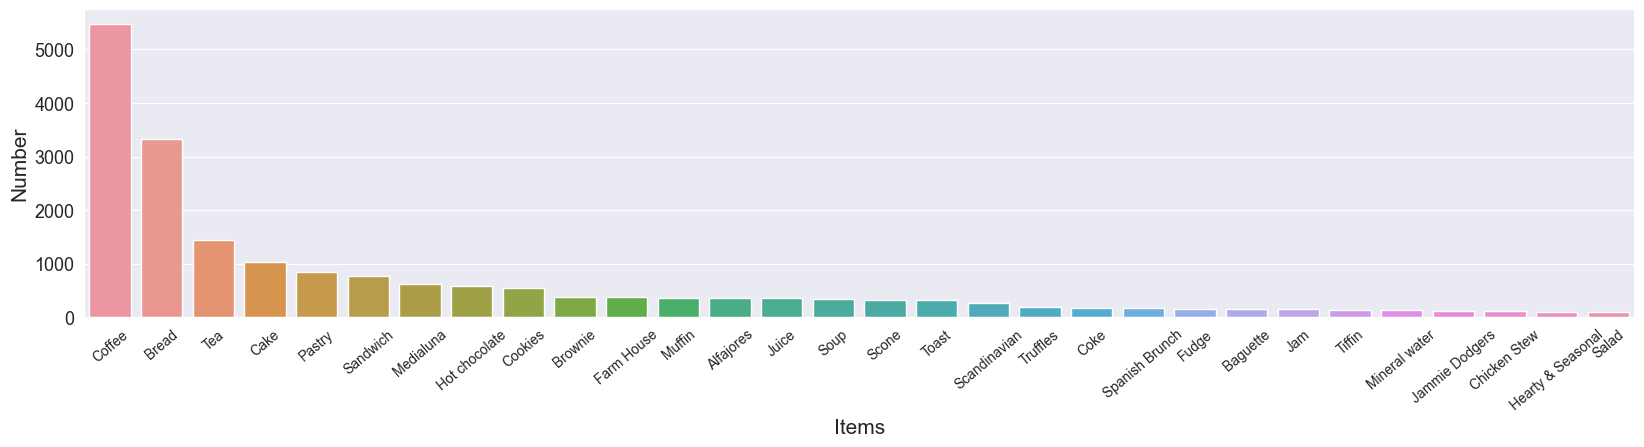

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

plt.figure(figsize=(20,4))
sns.barplot(x = data_frame.Item.value_counts().head(30).index, 
            y = data_frame.Item.value_counts().head(30).values)
plt.xlabel('Items', size=15)
plt.xticks(rotation=40)
plt.ylabel('Number', size=15)
plt.yticks(size=13)
plt.show()

在本次分析过程中，我们仅对 Item 之间的频繁模式进行挖掘。

下面我们丢弃无关属性 `date_time`, `period_day`, `weekday_weekend` 并对属于同一笔交易的商品进行合并：

In [48]:
data = []

for t_id in data_frame['Transaction'].unique():
    # 筛选 transaction_id 相同的记录
    data.append(data_frame[data_frame['Transaction'] == t_id]['Item'].unique().tolist())

重新整合后得到的 `data` 是一个二维数组，结构如下：

In [49]:
print("[")

for i in range(0, 10):
    print("  ", data[i], ",")

print("    ...")
print("]")

[
   ['Bread'] ,
   ['Scandinavian'] ,
   ['Hot chocolate', 'Jam', 'Cookies'] ,
   ['Muffin'] ,
   ['Coffee', 'Pastry', 'Bread'] ,
   ['Medialuna', 'Pastry', 'Muffin'] ,
   ['Medialuna', 'Pastry', 'Coffee', 'Tea'] ,
   ['Pastry', 'Bread'] ,
   ['Bread', 'Muffin'] ,
   ['Scandinavian', 'Medialuna'] ,
    ...
]


## 2 Apriori 算法实现

- Apriori 算法是一种用于挖掘关联规则的算法，它的基本思想是利用频繁项集和支持度来发现数据集中的关联性。通过逐层扫描数据集，生成频繁项集，并由此推导出高置信度的关联规则。

- 具体来说，该算法需要设定一个最小支持度阈值，对于每个项集，统计其在所有事务中的出现次数，只有出现次数不小于阈值的项集才能称为频繁项集。然后，用频繁项集来生成更大的项集，直到无法继续生成为止。

- 对算法过程的描述如下：

    1. 令 `k = 1`，扫描数据库并收集所有满足 `minimum support` 的 Item 以构建 `frequent 1-itemset`

    2. 从长度为 `frequent k-itemset` 中生成 `frequent (k+1)-itemset`

    3. 令 `k = k+1` 并重复步骤2，直至不能继续产生 `frequent (k+1)-itemset`

下面是对 Apriori 算法的一个实现：
    

In [50]:
class Apriori(object):
    def __init__(self, transactions, min_sup):
        self.transactions = transactions
        # 实际的 minimum support = min_sup/100
        self.min_sup = min_sup
        self.support_hash = {}


    # 生成 frequent 1-itemset
    def gen_freq_1(self):
        # 1-candidate itemset
        C1 = []
        # transaction 中的每一种 item 都是 1-candidate itemset 的成员
        for t in self.transactions:  
            for item in t:  
                if [item] not in C1: 
                    C1.append([item])  
        C1 = [frozenset(item) for item in C1]

        # 1-itemset
        L1 = []
        for item in C1: # 统计每个 candidate 的出现次数
            support = sum(1 for t in self.transactions if item.issubset(t)) / len(self.transactions) * 100
            # 选取超过 minimum support 的 candidate
            if support >= self.min_sup:
                L1.append(item)
                self.support_hash[item] = support
        L1.sort()
        return L1
    
    def gen_freq_k(self, L):
        # k+1-candidate itemset
        Ck = []
        k = len(L[0])
        # 计self-joining (L*L)
        for itemset1 in L:
            for itemset2 in L:
                if itemset1 != itemset2:
                    union = itemset1 | itemset2
                    if len(union) == k+1 and union not in Ck:
                        Ck.append(union)
        Ck = [frozenset(item) for item in Ck]
        # k+1_itemset
        Lk = []
        for item in Ck:
            support = sum(1 for t in self.transactions if item.issubset(t)) / len(self.transactions) * 100
            if support >= self.min_sup:
                Lk.append(item)
                self.support_hash[item] = support
        Lk.sort()
        return Lk

    # Apriori 算法主循环
    def apriori(self):
        L = []
        Lk = self.gen_freq_1()
        # 当不能继续生成 k-itemset 时退出循环
        while len(Lk) > 0:
            L += Lk
            Lk = self.gen_freq_k(Lk)
        return L

    # 频繁模式挖掘
    def gen_pattern(self, min_conf):
        L = self.apriori()
        pattern = []
        for item1 in L:
            for item2 in L:
                if item1 != item2 and item1.issubset(item2):
                        # 支持度计算
                        confidence = self.support_hash[item2] / self.support_hash[item1] * 100
                        if confidence >= min_conf:
                            pattern.append((item1, item2 - item1, confidence))
        return pattern

### 2.1 (测试) 生成 Frequent Itemset

我们尝试在数据集上应用算法生成 Frequent Itemset 以检验初步成果：

In [51]:
# minimum support = 1%
test = Apriori(transactions=data, min_sup=1)

print("当 minimum support = 1% 时，产生的 frequent itemset 如下：")
print("[")
count = [0, 0, 0]
for s in test.apriori():
    count[len(s)-1] += 1
    print("  ", s, ",")
print("]")

print("\nfrequent itemset 概况：")
for i in range(0, len(count)):
    print("  len = ", i+1 , "的 freq itemset", count[i],"个")

当 minimum support = 1% 时，产生的 frequent itemset 如下：
[
   frozenset({'Bread'}) ,
   frozenset({'Scandinavian'}) ,
   frozenset({'Hot chocolate'}) ,
   frozenset({'Jam'}) ,
   frozenset({'Cookies'}) ,
   frozenset({'Muffin'}) ,
   frozenset({'Coffee'}) ,
   frozenset({'Pastry'}) ,
   frozenset({'Medialuna'}) ,
   frozenset({'Tea'}) ,
   frozenset({'Mineral water'}) ,
   frozenset({'Farm House'}) ,
   frozenset({'Fudge'}) ,
   frozenset({'Juice'}) ,
   frozenset({'Hearty & Seasonal'}) ,
   frozenset({'Soup'}) ,
   frozenset({'Cake'}) ,
   frozenset({'Coke'}) ,
   frozenset({'Sandwich'}) ,
   frozenset({'Alfajores'}) ,
   frozenset({'Brownie'}) ,
   frozenset({'Truffles'}) ,
   frozenset({'Jammie Dodgers'}) ,
   frozenset({'Tiffin'}) ,
   frozenset({'Toast'}) ,
   frozenset({'Scone'}) ,
   frozenset({'Salad'}) ,
   frozenset({'Chicken Stew'}) ,
   frozenset({'Spanish Brunch'}) ,
   frozenset({'Baguette'}) ,
   frozenset({'Bread', 'Hot chocolate'}) ,
   frozenset({'Bread', 'Cookies'}) ,
   fr

### 2.2 频繁模式挖掘

对 `minimun support = 1%`, `minimum confidence = 70%` 的情况进行频繁模式挖掘：

In [72]:
t_1_70 = Apriori(transactions=data, min_sup=1)

print("min_support = 1%, min_confidence = 70%:")
print("-------------------------------------------------")

print('{0:<20}'.format("Item-1"), '{0:<20}'.format("Item-1"), '{0:<8}'.format("Conf(%)"))
for i in t_1_70.gen_pattern(min_conf=70):
    print(i[0], i[1], '{:.2f}'.format(i[2]))

min_support = 1%, min_confidence = 70%:
-------------------------------------------------
Item-1               Item-1               Conf(%) 
frozenset({'Toast'}) frozenset({'Coffee'}) 70.44


> 可以发现在此限制下得到的模式有亿些少，下面对模式 `Toast + Coffee` 进行验证

## 3 Pattern Evaluation

### 3.1 Lift

我们对购买 `Toast / Coffee` 的相关信息进行统计：

In [84]:
# 0 - T&C, 1 - OnltT, 2 - OnlyC, 3 - notBoth
count_TC = [0, 0, 0, 0]

for items in data:
    flagT = 'Toast' in items
    flagC = 'Coffee' in items
    if flagT and flagC:
        count_TC[0] += 1
    elif flagT:
        count_TC[1] += 1
    elif flagC:
        count_TC[2] += 1
    else:
        count_TC[3] += 1

print("统计结果为：", count_TC)

统计结果为： [224, 94, 4304, 4843]


统计结果如下表所示：

| | Toast | Not Toast | Sum(row) |
|:--|:--:|:--:|:--|
| Coffee | 224 |4304 | 4528|
| Not Cofee |94 |4843 |4937 |
| Sum(col) | 318| 9147| 9465|

我们按照如下公式计算 $ Lift $:
$$
    lift = \frac{P(A \cup B)}{P(A) * P(B)}
$$

计算结果如下：
$$
    \left\{
        \begin{align*}
        &lift(T,C) = \frac{224/9465}{318/9465*4528/9465} = 1.47 \\
        &lift(T,\neg C) = \frac{94/9465}{318/9465*4937/9465} = 0.57
        \end{align*}
    \right.
$$

=> 从上述数据来看，推论 $ 用户购买 Toast \Rightarrow 用户还会购买 Coffee $ 是较为合理的。

### 3.2 Imbalance Ratio

我们按照如下公式计算 Imbalance Ratio：
$$
    IR(A,B) = \frac{\left| sup(A) - sup(B) \right|}{sup(A) + sup(B) - sup(A \cup B)}
$$

In [95]:
# 获取所需的 support 值
sup_T = t_1_70.support_hash[frozenset({'Toast'})]
sup_C = t_1_70.support_hash[frozenset({'Coffee'})]
sup_TC = t_1_70.support_hash[frozenset({'Toast','Coffee'})]

print("sup(Toast) =", sup_T)
print("sup(Coffet) =",sup_C )
print("sup(T&C) =", sup_TC)

# 计算 IR
ir = abs(sup_T-sup_C)/(sup_T+sup_C-sup_TC)
print("------------------------------")
print("IR(T,C) =", ir)

sup(Toast) = 3.3597464342313788
sup(Coffet) = 47.839408346539884
sup(T&C) = 2.3666138404648707
------------------------------
IR(T,C) = 0.9108610990913026


=> 可以看出非常的不平衡（救命）

### 3.3 模式应用建议

从上面的分析中可以看出，客户在网上订购 Toast 后同时购买 Coffee 的模式是较为频繁的：

- 从交互设计角度：我们可以使点单页面中 Toast & Coffee 的选项卡连续，方便用户操作

- 从促销角度：

    - 我们可以在用户将 Toast 类产品添加至购物车时，弹出 Coffee 的优惠弹窗，提高对应的销量

    - 退出 Toast + Coffee 的捆绑销售套餐